In [2]:
import os
import cv2
import glob
import sys 
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from src import PROJECT_DIR, MODEL_DIR
from src.dataset import VDAODataset
from src.resnet import Resnet50
from src.utils import threshold, opening, closing, erosion, dilation

LGBM_DIR     = os.path.join(MODEL_DIR, 'elastic')

resnet = Resnet50('cuda' if torch.cuda.is_available() else 'cpu')


ModuleNotFoundError: No module named 'base'

In [2]:
import numpy as np
def calculate_diff(ref_frame_feat, tar_frame_feat, align, idx, lgbm, subbox=True, lg_class=True):

    feat_tar = resnet.get_features(tar_frame_feat[None, :], 'residual3')
    feat_ref = resnet.get_features(ref_frame_feat[None, :], 'residual3')
    print(feat_ref.shape)
    
    if lg_class:

        feat     = torch.cat((feat_tar, feat_ref), 0)
        diff     = lgbm_opt.predict(feat.view(512,-1).T.cpu().detach().numpy()).reshape((90,160))
    else:

        diff = torch.sqrt(((feat_tar - feat_ref)**2).sum(axis=0)).numpy()
        diff = (diff - diff.min())/(diff.max() - diff.min())
        
    diff = cv2.resize(diff, dsize=(1280,720), interpolation=cv2.INTER_CUBIC) 
    line = align.loc[idx,:]
    box_mask = np.zeros((720,1280))
    if subbox:
        if not align.subbox_1.isna()[idx]:
            box = [int(k) if int(k)>0 else 0  for k in line.subbox_1.split(', ')]
            box_mask[box[1]:box[3], box[0]:box[2]] = 1
            
            if not align.subbox_2.isna()[idx]:
                box = [int(k) if int(k)>0 else 0  for k in line.subbox_2.split(', ')]
                box_mask[box[1]:box[3], box[0]:box[2]] = 1    
            
            if not align.subbox_3.isna()[idx]:
                box = [int(k) if int(k)>0 else 0  for k in line.subbox_3.split(', ')]
                box_mask[box[1]:box[3], box[0]:box[2]] = 1           
        else:
            box = [int(k) if int(k)>0 else 0 for k in line.bounding_box.split(', ') ]
            box_mask[box[1]:box[3], box[0]:box[2]] = 1
    else:
        box = [int(k) if int(k)>0 else 0 for k in line.bounding_box.split(', ') ]
        box_mask[box[1]:box[3], box[0]:box[2]] = 1
  
    return box_mask*diff 
    
def morph(diff, t=0.1, o=11, c=21, e=35):

    dd = (diff > t)[None,:,:].astype('uint8')
    dd  = opening(dd, o)
    dd  = closing(dd, c)
    ddi  = dilation(dd, max(c//4,1))
    de  = erosion(dd, e)[0]
    dout = 127*ddi[0]+128*de
    dout = dout[36:-36,64:-64]
    contours_in, _     = cv2.findContours((dout > 200).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_out, _    = cv2.findContours((dout > 100).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    return dout, contours_in, contours_out

def plot_img(tar_frame, contours_in, contours_out):
    tt = tar_frame.copy()
    cv2.drawContours(tt, contours_in, -1, (25, 25, 201, 0.3), 1)
    cv2.drawContours(tt, contours_out, -1, (201, 25, 25, 0.3), 1)
    plt.figure(figsize=(9,12))
    plt.imshow(tt)
    plt.axis('off')
    plt.show()

In [3]:
fold = 1 # 8 - completed
lgbm_opt = pickle.load(open(LGBM_DIR+ 'lgbm_fold{0:02d}_split{1:02d}.pkl'.format(fold,1), 'rb'))
dataset      = VDAODataset(fold = fold, split = 0, type = 'validation', alignment = 'geometric', transform = False)
dataset_feat = VDAODataset(fold = fold, split = 0, type = 'validation', alignment = 'geometric', transform = True)
dataset.align_df = dataset.align_df[(dataset.align_df.num_pixels==0) & (~dataset.align_df.bounding_box.isna())]
silhouettes = [dataset.__getitem__(ii)[2] for ii in dataset.align_df.index]
corr_idx = np.where(np.array([s.sum() for s in silhouettes])==0)[0]
dd = dataset.align_df.iloc[corr_idx,:]
#dd = dataset.align_df
print(len(corr_idx))
print(dd.test_file.unique())
print([dd[dd.test_file == v].shape[0] for v in dd.test_file.unique()])

79
[ 2. 11. 37.]
[38, 38, 3]


torch.Size([256, 90, 160])


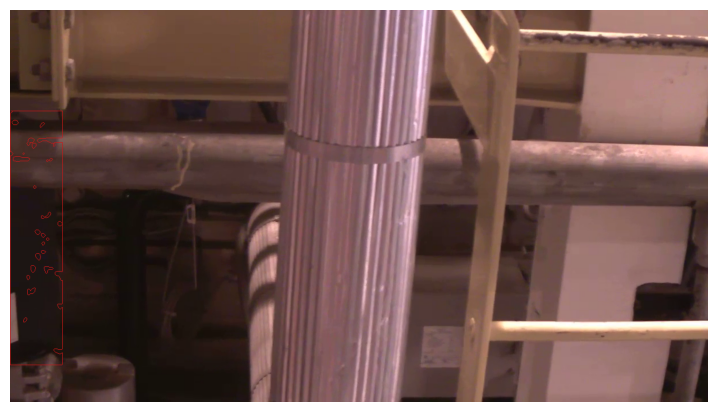

In [13]:
for k in range(0,1):
    idx = dataset.align_df.index[corr_idx[k]]
    ref_frame, tar_frame, sil_frame , _    = dataset.__getitem__(idx)
    ref_frame_feat, tar_frame_feat, _ , _  = dataset_feat.__getitem__(idx)
    diff = calculate_diff(ref_frame_feat, tar_frame_feat, dataset.align_df, idx, lgbm_opt, subbox=False, lg_class=True)
    dout, c_in, c_out = morph(diff, t=0, o=1, c=2, e=1)
    plot_img(tar_frame, c_in, c_out)
    #cv2.imwrite('/nfs/proc/luiz.tavares/VDAO_Database/{2}/sil/fold{0:02d}/{1:04d}.png'.format(fold,idx,'test'), dout)

In [5]:
tar_frame_feat.shape

torch.Size([3, 360, 640])

In [11]:
648//8

81